### Importing Libraries

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display, HTML
import pandas as pd

### Problem Definition

In [45]:
class MDP:
    def __init__(self):
        self.states = ['s1', 's2', 's3', 's4', 's5', 's6']
        self.actions = ['a1', 'a2', 'a3', 'a4', 'a5']
        self.start_state = 's1'
        self.terminal_state = 's6'
        
        # Transition probabilities: T[s][a][s'] = p
        self.T = {
            's1': {
                'a1': {'s1': 0.1, 's2': 0.9},
                'a2': {'s1': 0.3, 's3': 0.7},
                'a3': {}, 'a4': {}, 'a5': {}
            },
            's2': {
                'a1': {},
                'a2': {'s2': 0.2, 's3': 0.8},
                'a3': {'s2': 0.4, 's4': 0.6},
                'a4': {}, 'a5': {}
            },
            's3': {
                'a1': {},
                'a2': {},
                'a3': {'s3': 0.1, 's5': 0.9},
                'a4': {'s3': 0.5, 's6': 0.5},
                'a5': {}
            },
            's4': {
                'a1': {},
                'a2': {},
                'a3': {},
                'a4': {'s4': 0.3, 's5': 0.7},
                'a5': {'s4': 0.2, 's1': 0.8}
            },
            's5': {
                'a1': {},
                'a2': {},
                'a3': {},
                'a4': {},
                'a5': {'s5': 0.4, 's6': 0.6}
            },
            's6': {
                'a1': {'s6': 1.0},
                'a2': {}, 'a3': {}, 'a4': {}, 'a5': {}
            }
        }
        
        # Rewards: R[s] = r
        self.R = {
            's1': 0,
            's2': 0,
            's3': 0,
            's4': 0,
            's5': 0,
            's6': 1
        }
        
        # Discount factor
        self.gamma = 0.9
    
    def get_possible_actions(self, state):
        """Return possible actions at a state"""
        return [a for a in self.T[state] if self.T[state][a]]
    
    def get_transition_states_and_probs(self, state, action):
        """Return possible next states and their probabilities"""
        if action not in self.T[state]:
            return []
        return list(self.T[state][action].items())

### Visulization Of Problem

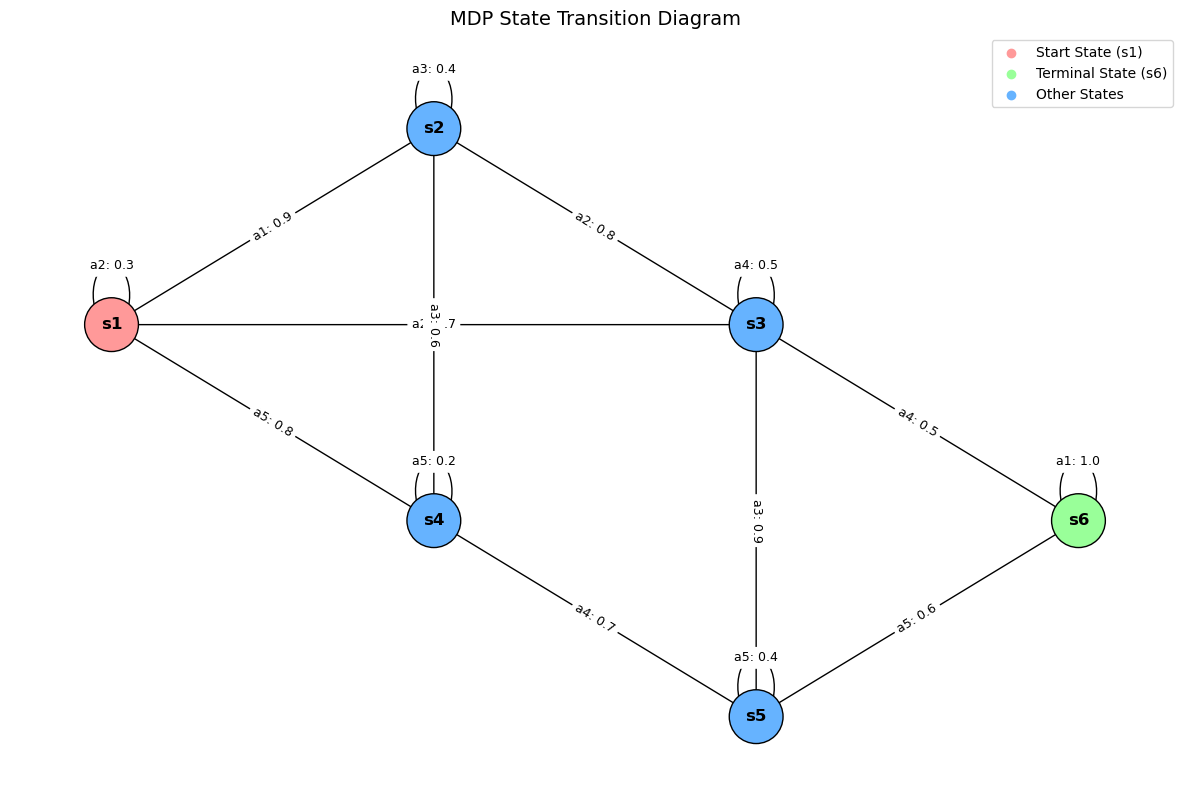

In [48]:
mdp = MDP()
transition_data = []
for s in mdp.states:
    for a in mdp.actions:
        if a in mdp.T[s] and mdp.T[s][a]:
            for s_prime, p in mdp.T[s][a].items():
                transition_data.append([s, a, s_prime, p])

# Create DataFrame
transition_df = pd.DataFrame(transition_data, columns=['s', 'a', 's\'', 'p'])
transition_df = transition_df.sort_values(by=['s', 'a'])

# Display with styling
def style_table(df):
    return df.style.set_properties(**{
        'text-align': 'center',
        'border': '1px solid black'
    }).set_table_styles([{
        'selector': 'th',
        'props': [('background-color', '#f2f2f2'), ('border', '1px solid black')]
    }])

display(HTML("<h3>Transition Table (T(s, a, s'))</h3>"))
display(style_table(transition_df))
reward_df = pd.DataFrame(list(mdp.R.items()), columns=['s', 'R(s)'])

display(HTML("<h3>Reward Table (R(s))</h3>"))
display(style_table(reward_df))

%matplotlib inline

def visualize_initial_mdp(mdp):
    G = nx.DiGraph()
    
    # Add nodes
    for s in mdp.states:
        G.add_node(s)
    
    # Add edges
    for s in mdp.states:
        for a in mdp.actions:
            if a in mdp.T[s]:
                for s_prime, p in mdp.T[s][a].items():
                    G.add_edge(s, s_prime, action=a, probability=p)
    
    # Position nodes
    pos = {
        's1': (0, 1),
        's2': (1, 1.5),
        's3': (2, 1),
        's4': (1, 0.5),
        's5': (2, 0),
        's6': (3, 0.5)
    }
    
    plt.figure(figsize=(12, 8))
    
    # Draw nodes
    node_colors = ['#ff9999' if s == mdp.start_state else 
                  '#99ff99' if s == mdp.terminal_state else 
                  '#66b3ff' for s in mdp.states]
    
    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color=node_colors, edgecolors='black')
    
    # Draw edges with labels
    edge_labels = {(u, v): f"{d['action']}: {d['probability']:.1f}" 
                   for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='->', arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
    
    # Node labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    
    # Legend
    plt.scatter([], [], c='#ff9999', label='Start State (s1)')
    plt.scatter([], [], c='#99ff99', label='Terminal State (s6)')
    plt.scatter([], [], c='#66b3ff', label='Other States')
    plt.legend(loc='upper right')
    
    plt.title('MDP State Transition Diagram', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_initial_mdp(mdp)

### Value Iteration Algorithm

In [51]:
def value_iteration(mdp, epsilon=0.001):
    # Initialize utilities to 0
    u = {s: 0 for s in mdp.states}
    u_prime = u.copy()
    
    while True:
        u = u_prime.copy()
        delta = 0
        
        for s in mdp.states:
            max_expected = -float('inf')
            
            for a in mdp.get_possible_actions(s):
                expected = 0
                for s_prime, p in mdp.get_transition_states_and_probs(s, a):
                    expected += p * u[s_prime]
                
                current_value = mdp.R[s] + mdp.gamma * expected
                if current_value > max_expected:
                    max_expected = current_value
            
            u_prime[s] = max_expected if mdp.get_possible_actions(s) else mdp.R[s]
            
            if abs(u_prime[s] - u[s]) > delta:
                delta = abs(u_prime[s] - u[s])
        
        if delta < epsilon * (1 - mdp.gamma) / mdp.gamma:
            break
    
    return u

def extract_policy(mdp, u):
    """Extract optimal policy from utilities"""
    policy = {}
    for s in mdp.states:
        max_utility = -float('inf')
        best_action = None
        
        for a in mdp.get_possible_actions(s):
            expected = 0
            for s_prime, p in mdp.get_transition_states_and_probs(s, a):
                expected += p * u[s_prime]
            
            current_utility = mdp.R[s] + mdp.gamma * expected
            
            if current_utility > max_utility:
                max_utility = current_utility
                best_action = a
        
        policy[s] = best_action
    
    return policy

### For Visualizing And Printing Result

In [54]:
def visualize_mdp(mdp, u, policy):
    """Visualize the MDP with utilities and policy"""
    G = nx.DiGraph()
    
    # Add nodes with utilities
    for s in mdp.states:
        G.add_node(s, utility=u[s], reward=mdp.R[s])
    
    # Add edges with probabilities and actions
    for s in mdp.states:
        for a in mdp.get_possible_actions(s):
            for s_prime, p in mdp.get_transition_states_and_probs(s, a):
                G.add_edge(s, s_prime, action=a, probability=p)
    
    # Position nodes in a circle
    pos = nx.circular_layout(G)
    
    plt.figure(figsize=(12, 8))
    
    # Node colors based on utility
    utilities = [u[s] for s in mdp.states]
    min_util, max_util = min(utilities), max(utilities)
    normalized_utilities = [(u - min_util) / (max_util - min_util) if max_util != min_util else 0.5 
                           for u in utilities]
    cmap = plt.cm.viridis
    node_colors = [cmap(u) for u in normalized_utilities]
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color=node_colors)
    
    # Draw edges with labels
    edge_labels = {(u, v): f"{d['action']}: {d['probability']:.1f}" 
                   for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='->', arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
    
    # Node labels with utility and policy
    node_labels = {s: f"{s}\nR: {mdp.R[s]}\nU: {u[s]:.3f}\nÏ€: {policy.get(s, '-')}" 
                   for s in mdp.states}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)
    
    # Highlight starting and terminal states
    nx.draw_networkx_nodes(G, pos, nodelist=[mdp.start_state], node_size=2000, 
                          node_color=node_colors[mdp.states.index(mdp.start_state)], 
                          edgecolors='red', linewidths=3)
    nx.draw_networkx_nodes(G, pos, nodelist=[mdp.terminal_state], node_size=2000, 
                          node_color=node_colors[mdp.states.index(mdp.terminal_state)], 
                          edgecolors='green', linewidths=3)
    
    plt.title('MDP Visualization with Utilities and Optimal Policy\n(Red=Start, Green=Terminal)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def value_iteration_with_history(mdp, epsilon=0.001, max_iterations=50):
    """Value iteration that tracks utility history"""
    u_history = []
    u = {s: 0 for s in mdp.states}
    u_prime = u.copy()
    
    for _ in range(max_iterations):
        u = u_prime.copy()
        u_history.append(u.copy())
        delta = 0
        
        for s in mdp.states:
            max_expected = -float('inf')
            
            for a in mdp.get_possible_actions(s):
                expected = 0
                for s_prime, p in mdp.get_transition_states_and_probs(s, a):
                    expected += p * u[s_prime]
                
                current_value = mdp.R[s] + mdp.gamma * expected
                if current_value > max_expected:
                    max_expected = current_value
            
            u_prime[s] = max_expected if mdp.get_possible_actions(s) else mdp.R[s]
            
            if abs(u_prime[s] - u[s]) > delta:
                delta = abs(u_prime[s] - u[s])
        
        if delta < epsilon * (1 - mdp.gamma) / mdp.gamma:
            break
    
    return u_history

# Display the table with styling
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

### Running All

In [73]:
print("Running value iteration...")
utilities = value_iteration(mdp)
print("\nFinal Utilities:")
for s in mdp.states:
    print(f"{s}: {utilities[s]:.4f}")

# Extract optimal policy
policy = extract_policy(mdp, utilities)
print("\nOptimal Policy:")
for s in mdp.states:
    print(f"{s}: {policy.get(s, 'Terminal/No action')}")

Running value iteration...

Final Utilities:
s1: 7.0600
s2: 7.1830
s3: 8.1808
s4: 7.2806
s5: 8.4365
s6: 9.9990

Optimal Policy:
s1: a2
s2: a2
s3: a4
s4: a4
s5: a5
s6: a1


### Table View

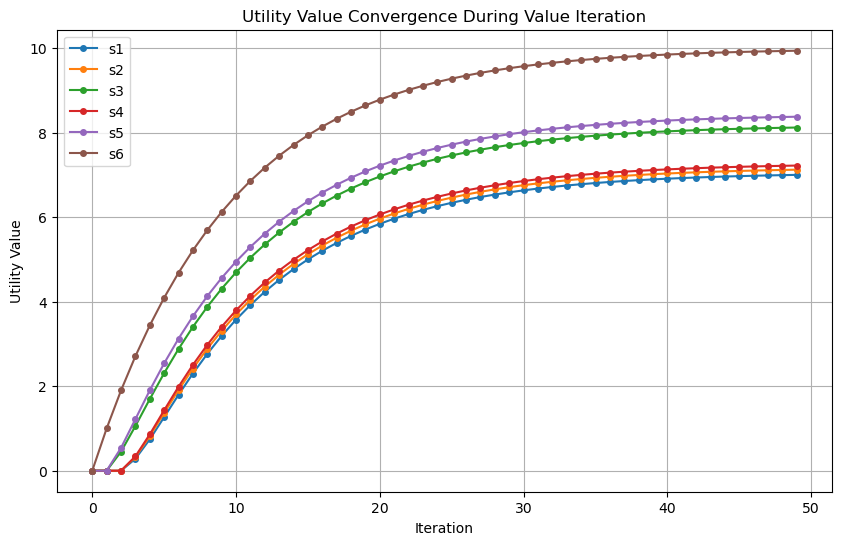

In [80]:
utility_history = value_iteration_with_history(mdp)

# Prepare data for the table
table_data = []
for iteration, utilities in enumerate(utility_history):
    row = {'Iteration': iteration}
    for state in mdp.states:
        row[state] = f"{utilities[state]:.4f}"
    table_data.append(row)

# Create DataFrame
utility_df = pd.DataFrame(table_data)
utility_df.set_index('Iteration', inplace=True)

display(HTML("<h3>Utility Values vs Iterations</h3>"))
display(utility_df.style.apply(highlight_max))

iterations = range(len(utility_history))
state_data = {s: [] for s in mdp.states}

for u in utility_history:
    for s in mdp.states:
        state_data[s].append(u[s])

# Plot
plt.figure(figsize=(10, 6))
for s in mdp.states:
    plt.plot(iterations, state_data[s], label=s, marker='o', markersize=4)

plt.xlabel('Iteration')
plt.ylabel('Utility Value')
plt.title('Utility Value Convergence During Value Iteration')
plt.legend()
plt.grid(True)
plt.show()

### Visualize

D:\anaconda\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


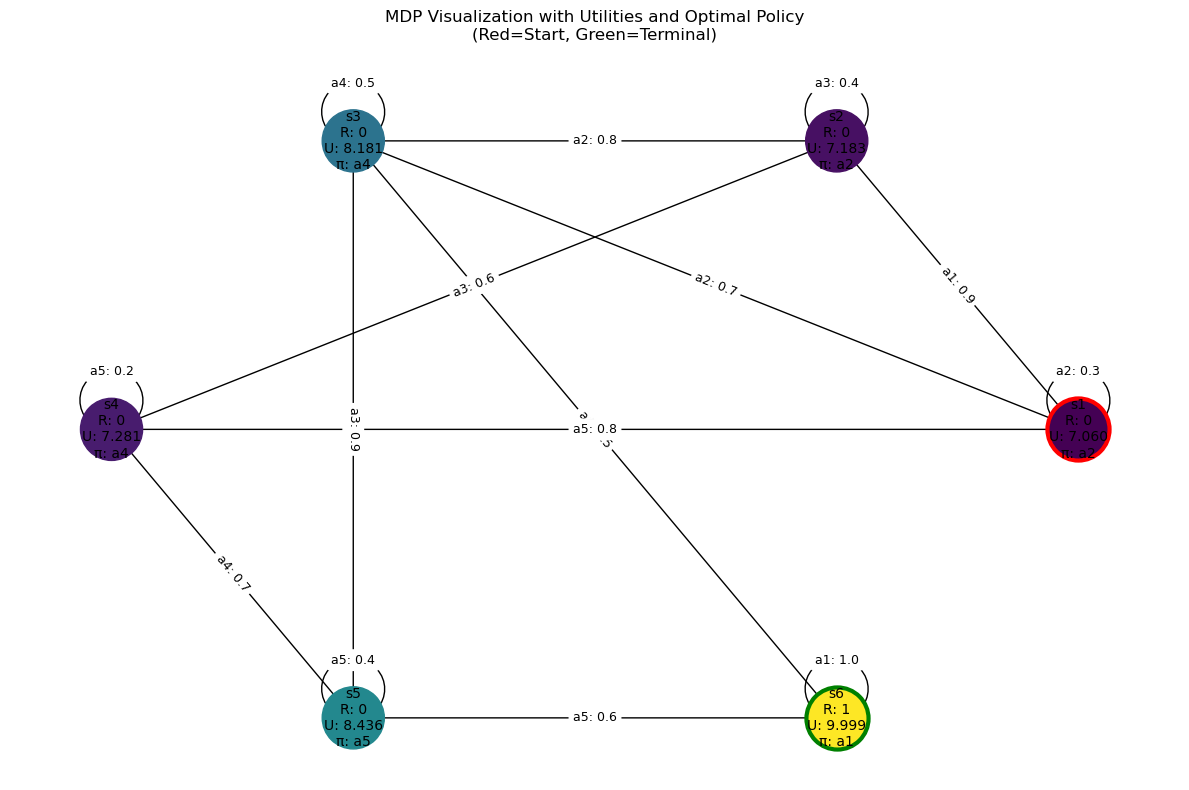

In [67]:
# Visualizations
visualize_mdp(mdp, utilities, policy)